<a href="https://colab.research.google.com/github/nimasteryang/AndroidOnStack/blob/main/data_process.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install required packages.
!pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html
!pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html
!pip install -q torch-geometric

In [85]:
from gensim.models.word2vec import Word2Vec
import re
import vul_model,parse
import pandas as pd
import torch
from torch_geometric.data import Data, InMemoryDataset

In [3]:
filename = "/content/devign_one_output.json"
df = pd.read_json(filename)
df.head()

,target,func,CPG,CDG,DDG,No2St
0,0,"static void v4l2_free_buffer(void *opaque, uin...","digraph v4l2_free_buffer { \r\n""1000100"" [lab...","digraph v4l2_free_buffer { \r\n""1000114"" [lab...","digraph v4l2_free_buffer { \r\n""1000100"" [lab...",{'1': [{'1000100': 'static void v4l2_free_buff...


In [50]:
code = df.func.values[0]
no_2_st = df.No2St.values[0]
no_2_st_dict = dict([int(key), value] for key, value in no_2_st.items()) 

W2V MODEL

In [5]:
token_code = parse.tokenizer(code)
model = Word2Vec([token_code], min_count=1)
print(model)

Word2Vec(vocab=40, size=100, alpha=0.025)


In [6]:
import pydot
import networkx as nx
%matplotlib inline
import matplotlib.pyplot as plt

In [67]:
cpg_graph = df.CPG.values[0]
pydot_graph = pydot.graph_from_dot_data(cpg_graph)
G_non_label = nx.drawing.nx_pydot.from_pydot(pydot_graph[0])
G_label = nx.relabel_nodes(G_non_label,lambda x: int(x) - 1000099)

In [23]:
def draw(_G):
  nx.draw(_G,nx.spring_layout(_G))
  labels = nx.draw_networkx_labels(_G, pos=nx.nx_pydot.graphviz_layout(_G, prog='dot'))
def ast_from_cpg(_cpg_graph):
  ast_edges = [(u,v,'') for u,v,d in _cpg_graph.edges(data = True) if "AST" in d['label']]
  ast_edges_attr = [(u,v,d) for u,v,d in _cpg_graph.edges(data = True) if "AST" in d['label']]
  ast_graph = _cpg_graph.edge_subgraph(ast_edges).copy()
  for u,v,d in ast_edges_attr:
    ast_graph.add_edge(u,v,label=d.get('label'))
  return ast_graph

def pdg_from_cpg(_cpg_graph):
  pdg_edges = [(u,v,'') for u,v,d in _cpg_graph.edges(data = True) if "DDG" in d['label']]
  pdg_edges_attr = [(u,v,d) for u,v,d in _cpg_graph.edges(data = True) if "DDG" in d['label']]
  pdg_graph = _cpg_graph.edge_subgraph(pdg_edges).copy()
  for u,v,d in pdg_edges_attr:
    pdg_graph.add_edge(u,v,label=d.get('label'))
  return pdg_graph

In [68]:
pdg_graph = pdg_from_cpg(G_label)
list(pdg_graph)

[1, 2, 3, 37, 38, 6, 10, 43, 12, 15, 16, 55, 24, 57, 62]

In [69]:
ast_graph = ast_from_cpg(G_label)
ast_graph.number_of_nodes()

62

In [70]:
pdg_edge_dict = {}
for u,v,d in pdg_graph.edges(data = True):
  pdg_edge_dict[u] = v

In [71]:
print(pdg_edge_dict)

{1: 55, 2: 6, 3: 62, 37: 62, 38: 62, 6: 62, 10: 62, 43: 62, 12: 55, 15: 62, 16: 62, 55: 62, 24: 38, 57: 62}


In [81]:
def generate_big_graph_int(edge_list):
    # This one is used to generate the overall PDG for a method
    in_ = []
    out_ = []
    for key,value in edge_list.items():
        in_.append(key)
        out_.append(value)
    output = torch.tensor([in_, out_])
    graph_data = Data(edge_list=torch.tensor(output))
    return graph_data

In [86]:
pdg_big_graph = generate_big_graph_int(pdg_edge_dict)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':


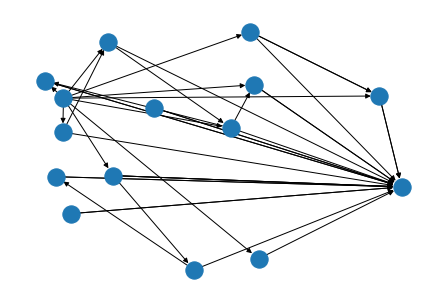

In [90]:
draw(pdg_graph)